In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
import scipy.ndimage
from scipy.ndimage import binary_closing
from scipy.ndimage import binary_fill_holes
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from models.UnrolledRef import UnrolledRef
from models.UnrolledTransformer import UnrolledTrans
from IFCNN import myIFCNN
from torchvision.transforms.functional import adjust_contrast 
from fastmri.data import transforms, subsample
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
torch.Size([256, 160, 2])


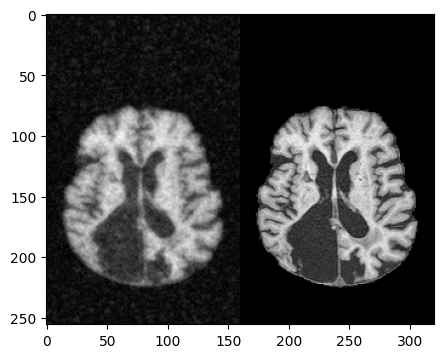

tensor(0.3211)


In [4]:

# Path to your NIfTI file
nii_file_target = './test_data/patient29b/T1_week152reg.nii'
img_target = nib.load(nii_file_target)
nii_file_ref = './test_data/patient29b/T1_week165regT1_week152.nii'
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,20]
reference = img_ref.get_fdata()[...,20]

random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
print(target_torch.shape)
torch_abs = torch.sqrt(target_torch[:,:,0].unsqueeze(0)**2 + target_torch[:,:,1].unsqueeze(0)**2)
target_contrast = adjust_contrast(torch_abs,1).permute(1,2,0)

phase = torch.atan2(target_torch[:,:,0],target_torch[:,:,1]).unsqueeze(2)
target_contrast = torch.cat((target_contrast*torch.cos(phase),target_contrast*torch.sin(phase)),dim=2)
print(target_contrast.shape)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
#fig.colorbar(im1, ax=axs)
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.show()
mask2 = sp.mri.poisson((256,160),5, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask2[128-10:128+9,80-8:80+7] = 1
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

mask_torch = T.kspace_crop(mask_torch,0.67)
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)

print(kspace_torch.shape)
print(mask_torch.shape)
kspace_torch = kspace_torch*mask_torch
fig, axs = plt.subplots(1, 1, figsize=(5,5))  # 1 row, 3 columns
# Plot each image in a subplot
concat = np.concatenate((np.abs(cplx.to_numpy(T.ifft2(kspace_torch))),np.abs(target)),axis =1)
im1 = axs.imshow(concat, cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.show()

s = (256/1.5)*(160/1.5)
print((torch.sum(mask_torch)/2)/s)


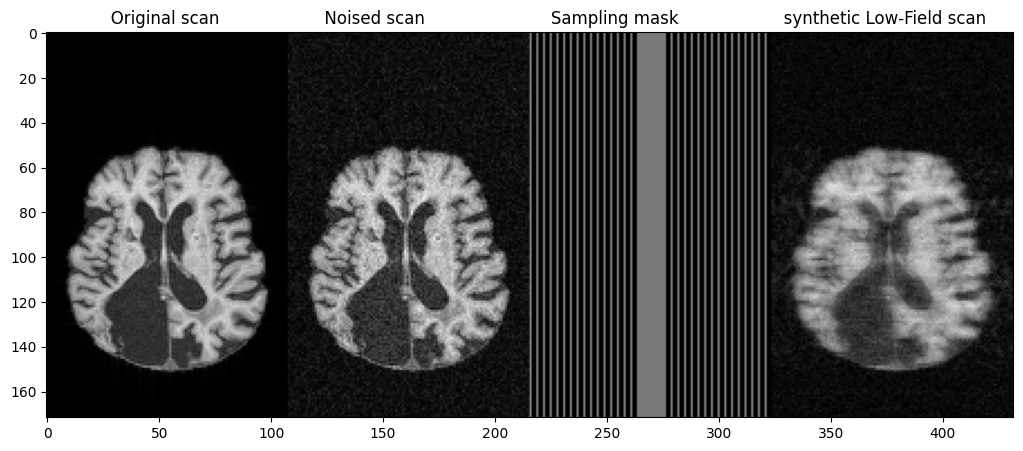

Mask torch size: (172, 108)
Acceleration factor R: 0.4074074074074074


In [5]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.kspace_cut(T.fft2(target_torch),0.67,0.67))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_noised = kspace_torch.clone()
kspace_noised = T.kspace_cut(kspace_noised,0.67,0.67)
kspace_torch = T.kspace_cut(kspace_torch,0.67,0.67)
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch_kspace = T.kspace_cut(reference_torch_kspace,0.67,0.67)
reference_torch = T.ifft2(reference_torch_kspace)
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(3)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]
mask = np.abs(cplx.to_numpy(kspace_torch))!=0
mask_torch = torch.stack([torch.tensor(mask).float(),torch.tensor(mask).float()],dim=2)
concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('       Original scan                    Noised scan                        Sampling mask                    synthetic Low-Field scan')
plt.show()

mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')


In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:

#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledPlug/model_5.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolled/model_80.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledNoLast/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x4_SAunrolledTransOF/model_15.pt"
checkpoint_file = "./L2_checkpoints_poisson_x2_MoDL_horizontal_LR/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolled_ref_transformer/model_30.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_test3/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_refnewarch/model_30.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_test2/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_refarchsig/model_30.pt"

checkpoint = torch.load(checkpoint_file,map_location=device)

In [8]:
params = checkpoint["params"]
single_MoDL = UnrolledModel(params).to(device)
#single_MoDL = MyNetwork(2,2).to(device)
#single_MoDL = Unrolled(params).to(device)

#single_MoDL = UnrolledRef(params).to(device)
#single_MoDL = UnrolledTrans(params).to(device)
single_MoDL.load_state_dict(checkpoint['model'])

shared weights


<All keys matched successfully>

In [9]:
kspace_torch.shape
reference_torch.shape

torch.Size([172, 108, 2])

In [10]:
with torch.no_grad():
    kspace_torch = kspace_torch.unsqueeze(0).to(device)
    mask_torch = mask_torch.unsqueeze(0).to(device)
    reference_torch = reference_torch.unsqueeze(0).to(device)
    im_out = single_MoDL(kspace_torch.float(),reference_torch,mask=mask_torch)

In [11]:

#pl.ImagePlot(cplx.to_numpy(T.ifft2(kspace_torch.cpu())))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(kspace_torch.cpu()))).squeeze(0))

In [12]:
#pl.ImagePlot(cplx.to_numpy(target_torch.cpu()))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))))

In [13]:
#pl.ImagePlot(cplx.to_numpy(im_out.cpu()))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(im_out.cpu())))))

torch.Size([1, 172, 108, 2])
(172, 108)


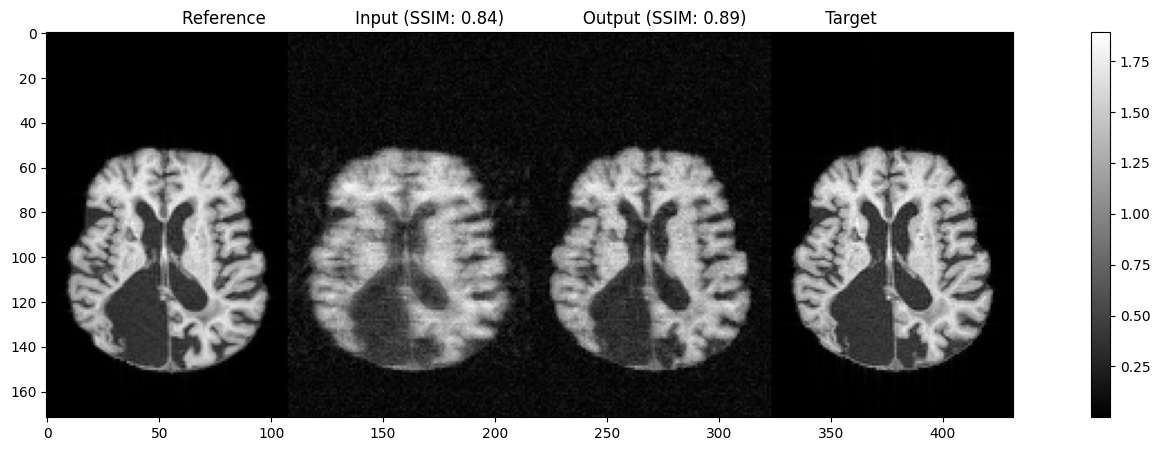

In [14]:
from skimage.metrics import structural_similarity as ssim
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

print(im_out.cpu().shape)
kspace_out = T.fft2(im_out.cpu().squeeze(0))
im_out = T.ifft2(kspace_out)

kspace_target = T.fft2(target_torch.cpu())
target_torch  = T.ifft2(kspace_target)

cplx_image_target = cplx.to_numpy(target_torch.cpu())
cplx_image_in = cplx.to_numpy(T.ifft2(kspace_torch.cpu())).squeeze(0)
cplx_image_out = cplx.to_numpy(im_out.cpu())
cplx_image_reference = cplx.to_numpy(reference_torch.cpu()).squeeze(0)

maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))
target_numpy_norm = np.abs(cplx_image_target)/maxval
input_numpy_norm = np.abs(cplx_image_in)/maxval
out_numpy_norm = np.abs(cplx_image_out)/maxval

# Area calib
# Find comparison area:
area = target_numpy_norm > 0.30
kernel = np.ones((10, 10)) / 25.0
#area = np.convolve(area, kernel, mode='constant', cval=0.0)
area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
area[area>0.009] = 1
structuring_element = np.ones((4,4))
area = binary_closing(area, structure=structuring_element)
area = binary_fill_holes(area)

target_numpy_norm = target_numpy_norm * area
input_numpy_norm = input_numpy_norm * area
out_numpy_norm = out_numpy_norm * area

psnr_in = compute_psnr(target_numpy_norm, input_numpy_norm,1)
psnr_out = compute_psnr(target_numpy_norm,out_numpy_norm,1)
data_range = maxval - minval
ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
ssim_out, _ = ssim(target_numpy_norm, out_numpy_norm, data_range=data_range, full=True)
"""
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()
"""
print(cplx_image_out.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (SSIM: {ssim_in:.2f})               Output (SSIM: {ssim_out:.2f})               Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.show()




(172, 108)
(172, 108)
(172, 108)


/tmp/ipykernel_2185061/726424829.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


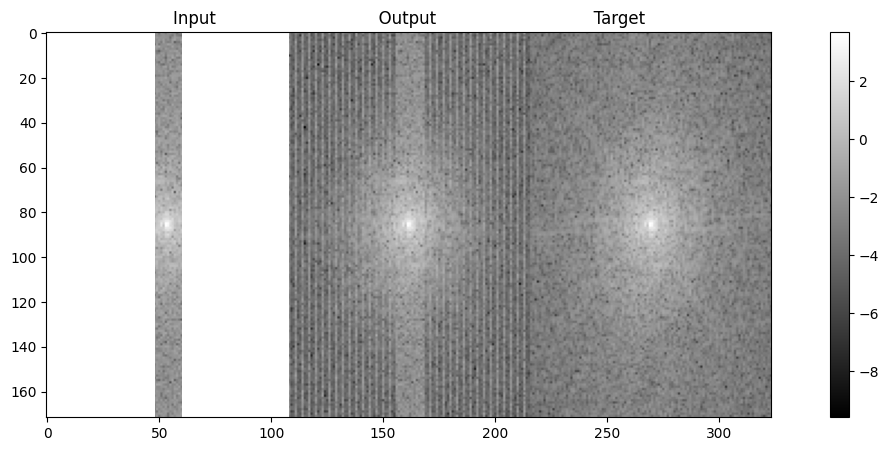

/tmp/ipykernel_2185061/726424829.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))


/home/tal/.local/lib/python3.10/site-packages/matplotlib/image.py:453: RuntimeWarning: invalid value encountered in double_scalars
  vmid = np.float64(self.norm.vmin) + dv / 2


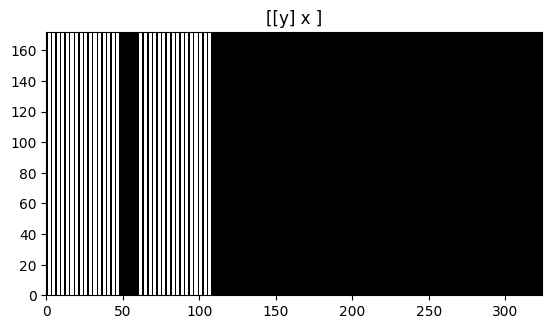

In [15]:
cplx_image_target = np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))
cplx_image_in = np.abs(cplx.to_numpy(kspace_torch.cpu()).squeeze(0))
cplx_image_out = np.abs(cplx.to_numpy(T.fft2(im_out.cpu())))
print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes

plt_concat = np.concatenate((cplx_image_in,cplx_image_out,cplx_image_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

####### Errors calculation #######

# Assuming img1 and img2 are PIL images or numpy arrays
# Convert PIL images to numpy arrays if needed
img_target = img_as_float(np.abs(cplx_image_target).copy())/np.max(np.abs(cplx_image_target))
img_in = img_as_float(np.abs(cplx_image_in)/np.max(cplx_image_in))/np.max(np.abs(cplx_image_in))
img_out = img_as_float(np.abs(cplx_image_out).copy())/np.max(np.abs(cplx_image_out))
img_reference = img_as_float(np.abs(cplx_image_reference).copy())/np.max(np.abs(cplx_image_reference))

####### Errors calculation #######

print(f'MSE input: {np.mean(np.abs(cplx_image_in-cplx_image_target)**2)}')
print(f'MSE output: {np.mean(np.abs(cplx_image_out-cplx_image_target)**2)}')

print(f'PSNR input: {T.PSNR(target_torch.cpu(), T.ifft2(kspace_torch.cpu()))}')
print(f'PSNR output: {T.PSNR(target_torch.cpu(), im_out.cpu().unsqueeze(0))}')

# Calculate SSIM values
data_range = img_target.max() - img_target.min()
#ssim_in, _ = ssim(img_target, img_in, data_range=data_range, full=True)
#ssim_out, _ = ssim(img_target, img_out, data_range=data_range, full=True)
cplx_im_out = cplx.to_numpy(im_out.cpu())
image_out = np.abs(cplx_im_out) / np.max(np.abs(cplx_im_out))
cplx_im_in = cplx.to_numpy( T.ifft2(kspace_torch.cpu()))
im_in = np.abs(cplx_im_in).squeeze(0) / np.max(np.abs(cplx_im_in))
cplx_im_target = cplx.to_numpy( target_torch.cpu())
im_target = np.abs(cplx_im_target) / np.max(np.abs(cplx_im_target))
data_range = im_target.max() - im_target.min()

print(im_target.shape)
print(im_in.shape)
ssim_in, _ = ssim(im_target, im_in, data_range=data_range, full=True)
ssim_out, _ = ssim(im_target, image_out, data_range=data_range, full=True)

print(f"SSIM input: {ssim_in:.4f}")
print(f"SSIM output: {ssim_out:.4f}")


MSE input: 0.024569811663353494
MSE output: 0.00983084924519062
PSNR input: tensor([18.4922], dtype=torch.float64)
PSNR output: tensor([20.6217])
(172, 108)
(172, 108)
SSIM input: 0.3976
SSIM output: 0.4516
